<div class="head0">
    <div class="head0__name">
        Examples for func module
    </div>
    <div class="head0__note">
        Fast multidimensional function interpolation by Chebyshev polynomials in the dense (numpy) or sparse (tensor train (TT) with cross approximation) format using Fast Fourier Transform (FFT).
    </div>
</div>

<div class="head2__note">
    For each interpolated function we presented the following plots:
    <ol>
        <li>Computational times (for numpy and tensor-train formats), including "prep" for construction of tensor of the function values on the Chebyshev grid, "calc" for construction of interpolation coefficients and "comp" for computation of interpolant in one given spatial point.</li>
        <li>Interpolation error (for numpy and tensor-train formats) for the set of uniform random points scaled to the interpolation limits.</li>
        <li>Compression factor for the cross approximation and the tensor-train format, including function evaluations (v.s. total grid size) and compressed tensor size (v.s. total tensor size).</li>
    </ol>
</div>

In [1]:
import numpy as np

from fpcross import init_jupyter, func_check, Grid, Func

init_jupyter()

Start |  2:14PM MSK on Oct 07, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Interpolation of 1-dimensional function
    </div>
    <div class="head1__note">
        Let consider 1D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x \right)}.
        $$
        Note that tensor-train format for 1D case works correct but not efficient since we cannot take advantage of the low-ranking representation of a multidimensional function.
    </div>
</div>

In [2]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ])

GR = Grid(d=1, n=[50], l=[[-3., 4.]])

In [3]:
FN = Func(GR, with_tt=False)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 1D, NP
------------------ Time
Prep             : 2.28e-04 sec. 
Calc             : 4.79e-03 sec. 
Comp (average)   : 5.19e-05 sec. 
Func (average)   : 4.50e-06 sec. 
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 7.18e-14
Error (mean)     : 3.58e-15
Error (min)      : 0.00e+00
------------------


In [4]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 1D, TT, eps= 1.00e-06
------------------ Time
Prep             : 1.41e-02 sec. 
Calc             : 1.41e-03 sec. 
Comp (average)   : 1.18e-05 sec. 
Func (average)   : 2.09e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:      200
Cross iterations :        2
Av. tt-rank      : 0.00e+00
Cross err (rel)  : 0.00e+00
Cross err (abs)  : 0.00e+00
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 6.84e-14
Error (mean)     : 4.64e-15
Error (min)      : 0.00e+00
------------------


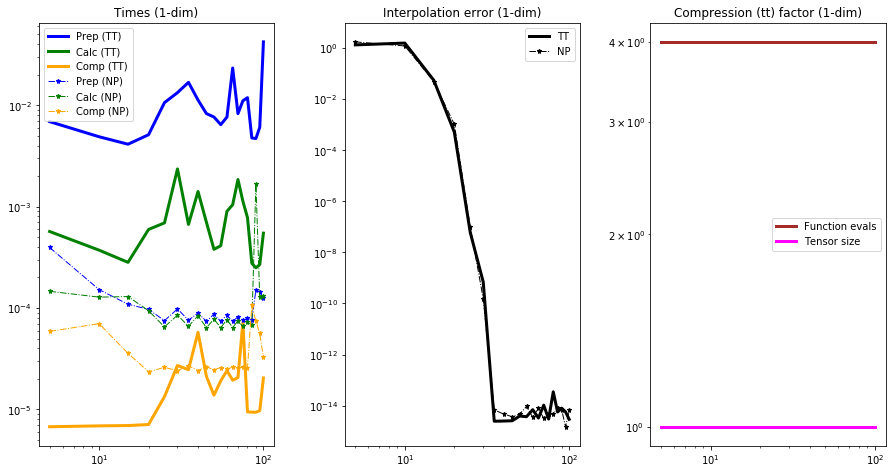

In [5]:
N_tt = np.arange(5, 101, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 2-dimensional function
    </div>
    <div class="head1__note">
        Let consider 2D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2}.
        $$
        Note that tensor-train format for 2D case works correct but not very efficient since we cannot take full advantage of the low-ranking representation of a multidimensional function.
    </div>
</div>

In [14]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ])

d = 2
n = [20, 24]
l = [[-3., 4.], [-2., 3.]]

GR = Grid(d=2, n=[20, 24], l=[
    [-3., 4.],
    [-2., 3.],
])

In [15]:
FN = Func(GR, with_tt=False)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 2D, NP
------------------ Time
Prep             : 7.64e-04 sec. 
Calc             : 7.05e-04 sec. 
Comp (average)   : 8.70e-05 sec. 
Func (average)   : 1.58e-06 sec. 
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 1.99e-02
Error (mean)     : 5.88e-04
Error (min)      : 4.72e-06
------------------


In [16]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 2D, TT, eps= 1.00e-06
------------------ Time
Prep             : 1.73e-02 sec. 
Calc             : 4.50e-04 sec. 
Comp (average)   : 1.49e-05 sec. 
Func (average)   : 2.41e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:     1056
Cross iterations :        3
Av. tt-rank      : 7.00e+00
Cross err (rel)  : 4.30e-16
Cross err (abs)  : 3.10e-14
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 6.52e-03
Error (mean)     : 3.94e-04
Error (min)      : 2.20e-06
------------------


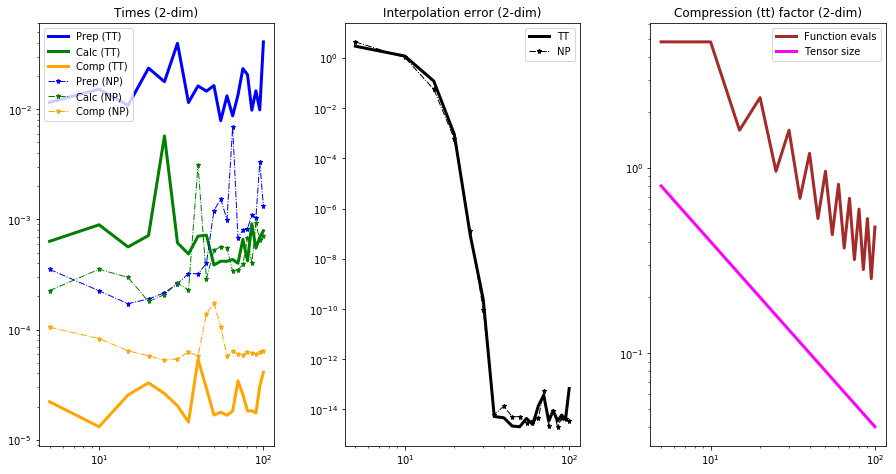

In [17]:
N_tt = np.arange(5, 101, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 3-dimensional function
    </div>
    <div class="head2__note">
        Let consider 3D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2}.
        $$
    </div>
</div>

In [18]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ]) + x[2, ] / 2.

GR = Grid(d=3, n=[20, 22, 24], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
])

In [19]:
FN = Func(GR, with_tt=False)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 3D, NP
------------------ Time
Prep             : 4.86e-03 sec. 
Calc             : 1.96e-03 sec. 
Comp (average)   : 1.17e-04 sec. 
Func (average)   : 4.60e-07 sec. 
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 4.25e-03
Error (mean)     : 3.20e-04
Error (min)      : 8.72e-08
------------------


In [20]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 3D, TT, eps= 1.00e-06
------------------ Time
Prep             : 2.99e-02 sec. 
Calc             : 7.58e-04 sec. 
Comp (average)   : 4.06e-05 sec. 
Func (average)   : 1.51e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:     3540
Cross iterations :        3
Av. tt-rank      : 7.50e+00
Cross err (rel)  : 4.30e-16
Cross err (abs)  : 1.50e-13
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 4.86e-03
Error (mean)     : 3.49e-04
Error (min)      : 1.08e-07
------------------


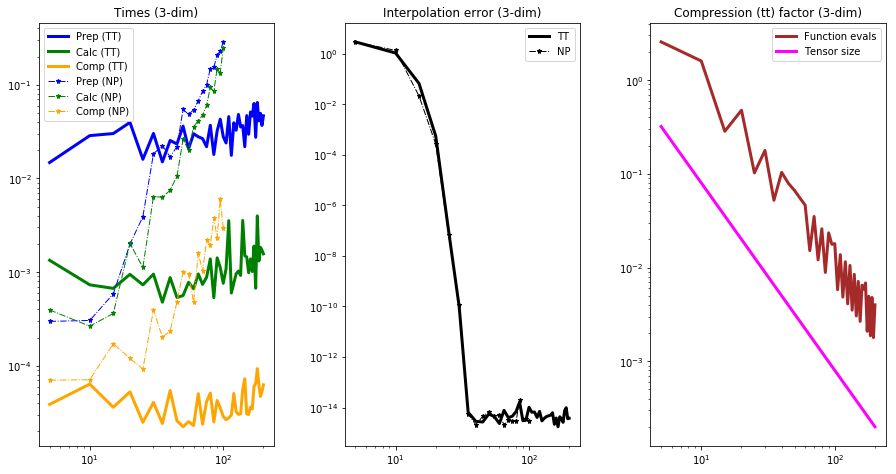

In [21]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 4-dimensional function
    </div>
    <div class="head2__note">
        Let consider 4D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2} \cdot x_4^2.
        $$
    </div>
</div>

In [22]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ]) + x[2, ] / 2. * x[3, ]**2

GR = Grid(d=4, n=[30, 31, 32, 33], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
    [-1., 3.],
])

In [23]:
FN = Func(GR, with_tt=False)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 4D, NP
------------------ Time
Prep             : 4.03e-01 sec. 
Calc             : 4.00e-01 sec. 
Comp (average)   : 4.65e-03 sec. 
Func (average)   : 4.10e-07 sec. 
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 5.94e-09
Error (mean)     : 2.42e-10
Error (min)      : 3.77e-12
------------------


In [24]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 4D, TT, eps= 1.00e-06
------------------ Time
Prep             : 5.37e-02 sec. 
Calc             : 1.48e-03 sec. 
Comp (average)   : 5.59e-05 sec. 
Func (average)   : 1.25e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:     8760
Cross iterations :        3
Av. tt-rank      : 7.30e+00
Cross err (rel)  : 6.40e-16
Cross err (abs)  : 2.30e-12
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 9.18e-10
Error (mean)     : 8.51e-11
Error (min)      : 2.69e-13
------------------


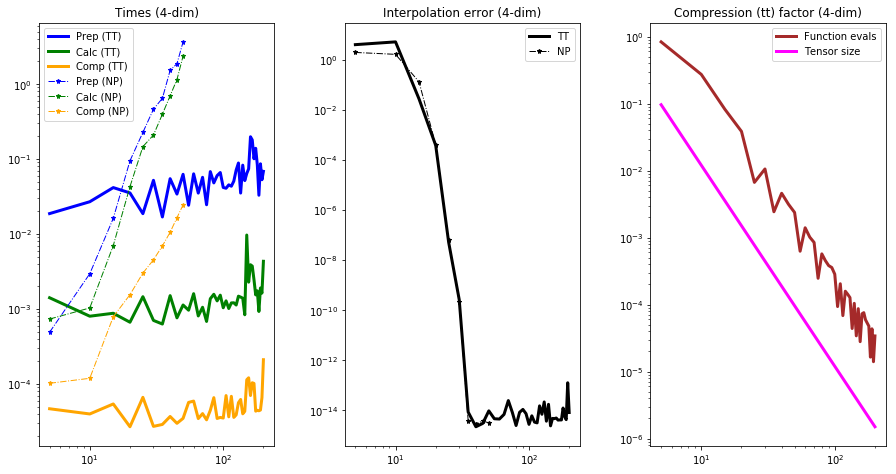

In [25]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 51, 5)
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 5-dimensional function
    </div>
    <div class="head2__note">
        Let consider 5D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2} \cdot x_4^2 + 3 \cos{\left( \pi x_5^2 \right)}.
        $$
    </div>
</div>

In [26]:
def func(x):
    f = 2. * np.sin(np.pi * x[0, ])
    f+= np.exp(-x[1, ])
    f+= x[2, ] / 2. * x[3, ]**2
    f+= 3. * np.cos(np.pi * x[4, ]**2)
    return f

GR = Grid(d=5, n=[22, 24, 26, 28, 30], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
    [-1., 3.],
    [-6., 1.],
])

In [27]:
FN = Func(GR, with_tt=False)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 5D, NP
------------------ Time
Prep             : 1.34e+01 sec. 
Calc             : 4.42e+00 sec. 
Comp (average)   : 4.83e-02 sec. 
Func (average)   : 1.16e-06 sec. 
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 6.99e+00
Error (mean)     : 9.34e-01
Error (min)      : 8.25e-04
------------------


In [28]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 5D, TT, eps= 1.00e-06
------------------ Time
Prep             : 6.33e-02 sec. 
Calc             : 7.95e-04 sec. 
Comp (average)   : 3.72e-05 sec. 
Func (average)   : 2.86e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:     9984
Cross iterations :        3
Av. tt-rank      : 7.00e+00
Cross err (rel)  : 7.80e-16
Cross err (abs)  : 1.20e-11
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 1.13e+01
Error (mean)     : 1.16e+00
Error (min)      : 1.06e-03
------------------


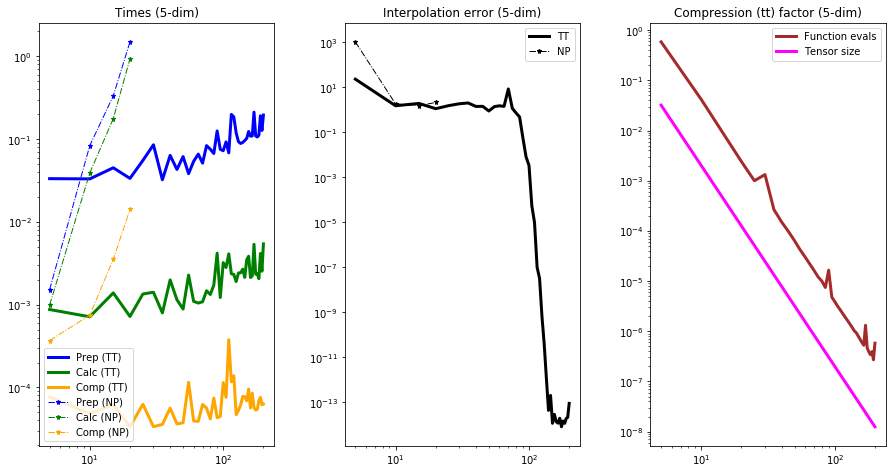

In [29]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 21, 5)
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 10-dimensional function
    </div>
    <div class="head2__note">
        Let consider 10D function of the form
        $$
        f(x) = \sum_{k=1}^{10} \sin{\left( \frac{\pi}{k} x_k^2 \right)}.
        $$
        Note that only tensor-train format may be used in this case of multidimensional function.
    </div>
</div>

In [30]:
def func(x):
    f = 0.
    for k in range(d):
        f+= np.sin(np.pi / (k+1.) * x[k, ]**2)
    return f

d = 10
n = np.linspace(50, 70, d, dtype='int')
l = []
for k in range(d):
    l.append([-2. - k * 0.2, +2. + k * 0.2])
    
GR = Grid(d, n, l)

In [31]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 10D, TT, eps= 1.00e-06
------------------ Time
Prep             : 1.47e-01 sec. 
Calc             : 2.41e-03 sec. 
Comp (average)   : 7.49e-05 sec. 
Func (average)   : 2.28e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:    56516
Cross iterations :        3
Av. tt-rank      : 7.10e+00
Cross err (rel)  : 2.10e-15
Cross err (abs)  : 3.40e-06
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 8.13e-12
Error (mean)     : 2.33e-13
Error (min)      : 1.65e-15
------------------


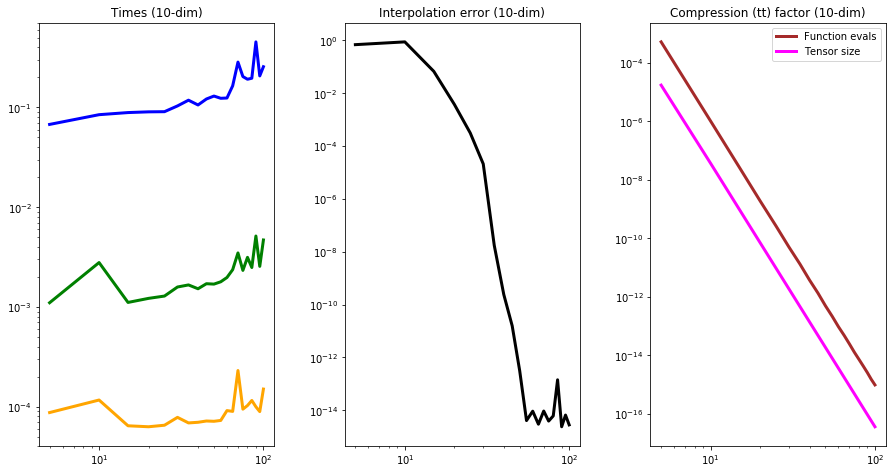

In [32]:
N_tt = np.arange(5, 101, 5)
N_np = None
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 99-dimensional function
    </div>
    <div class="head2__note">
        Let consider 99D function of the form
        $$
        f(x) = \sum_{k=1}^{99} \sin{\left( \frac{\pi}{k} x_k^2 \right)}.
        $$
        Note that only tensor-train format may be used in this case of multidimensional function.
    </div>
</div>

In [44]:
def func(x):
    f = 0.
    for k in range(d):
        f+= np.sin(np.pi / (k+1.) * x[k, ]**2)
    return f

d = 99
n = np.linspace(20, 40, d, dtype='int')
l = []
for k in range(d):
    l.append([-2. - k * 0.01, +2. + k * 0.015])

GR = Grid(d, n, l)

In [33]:
FN = Func(GR, eps=1.E-6)
FN.init(func).prep().calc().info(n_test=100)

------------------ Intertain
Format           : 10D, TT, eps= 1.00e-06
------------------ Time
Prep             : 2.33e-01 sec. 
Calc             : 2.69e-03 sec. 
Comp (average)   : 8.86e-05 sec. 
Func (average)   : 2.25e-07 sec. 
------------------ Cross appr. parameters
nswp             :      200
kickrank         :        1
rf               : 2.00e+00
------------------ Cross appr. result
Func. evaluations:    96300
Cross iterations :        3
Av. tt-rank      : 7.10e+00
Cross err (rel)  : 3.30e-15
Cross err (abs)  : 7.30e-05
------------------ Test for uniform random points
Number of points :      100
Error (max)      : 5.64e-14
Error (mean)     : 3.78e-15
Error (min)      : 0.00e+00
------------------


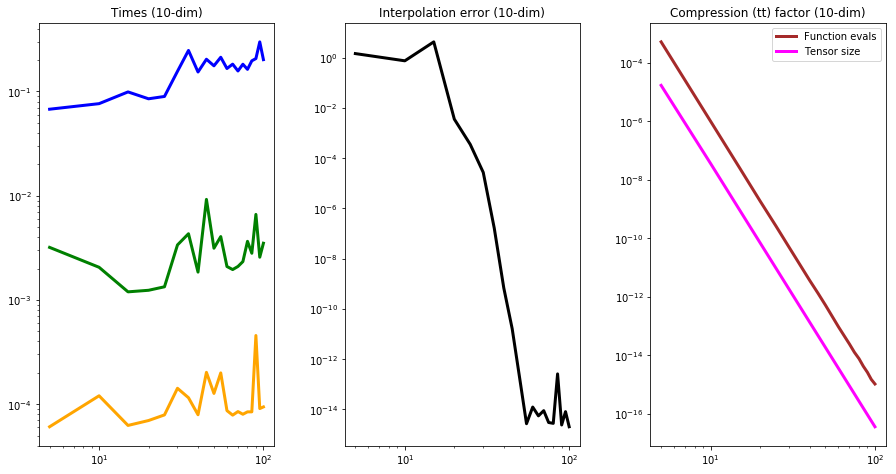

In [34]:
N_tt = np.arange(5, 101, 5)
N_np = None
func_check(N_tt, N_np, GR, func)

<div class="end"></div>

<div class="head1">
    <div class="head1__name">
        TMP (DRAFT)
    </div>
</div>

<div class="head1">
    <div class="head1__name">
        Direct construction of 1D Chebyshev interpolation
    </div>
</div>

<div class="head2">
    <div class="head2__name">
        Direct construction of 1D Chebyshev interpolation for one function
    </div>
</div>

Max relative error for interpolation points : 1.33e-15
Max relative error for random points        : 8.36e-16


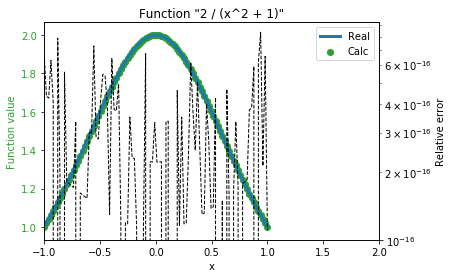

In [10]:
def func_f(x):
    return 2. / (x**2 + 1.)

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u = func_f(x)
a = Intertrain.interpolate(u)

u = u.reshape(-1, 1)
v = Intertrain.polynomials(x, N).T@a
e = np.abs((v - u) / u)
print('Max relative error for interpolation points : %-8.2e'%np.max(e))

x = np.linspace(-1., 1., 100)
u = func_f(x).reshape(-1, 1)
v = Intertrain.polynomials(x, N).T@a
e = np.abs((v - u) / u)
print('Max relative error for random points        : %-8.2e'%np.max(e))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_title('Function "2 / (x^2 + 1)"')
ax1.set_xlabel('x')
ax1.set_xlim(-1, 2)

ax1.set_ylabel('Function value', color='tab:green')
ax1.plot(x, u, color='tab:blue', linewidth=3, label='Real')
ax1.scatter(x, v, color='tab:green', label='Calc')
ax1.tick_params(axis='y', which='both', labelcolor='tab:green')
ax1.legend(loc='best')

ax2.set_ylabel('Relative error', color='black')
ax2.plot(x, e, '--', linewidth=1, color='black')
ax2.tick_params(axis='y', which='both', labelcolor='black')
ax2.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Direct construction of 1D Chebyshev interpolation for several functions
    </div>
</div>

Max relative error for random points : 8.36e-16 | Func: 2 / (x^2 + 1)
Max relative error for random points : 8.72e-16 | Func: e^{x^2/4}
Max relative error for random points : 1.40e-15 | Func: sin(\pi * x^2) + 2 / (x + 2)
Max relative error for random points : 9.14e-14 | Func: cos(\pi * x^3) - 2 / x^2


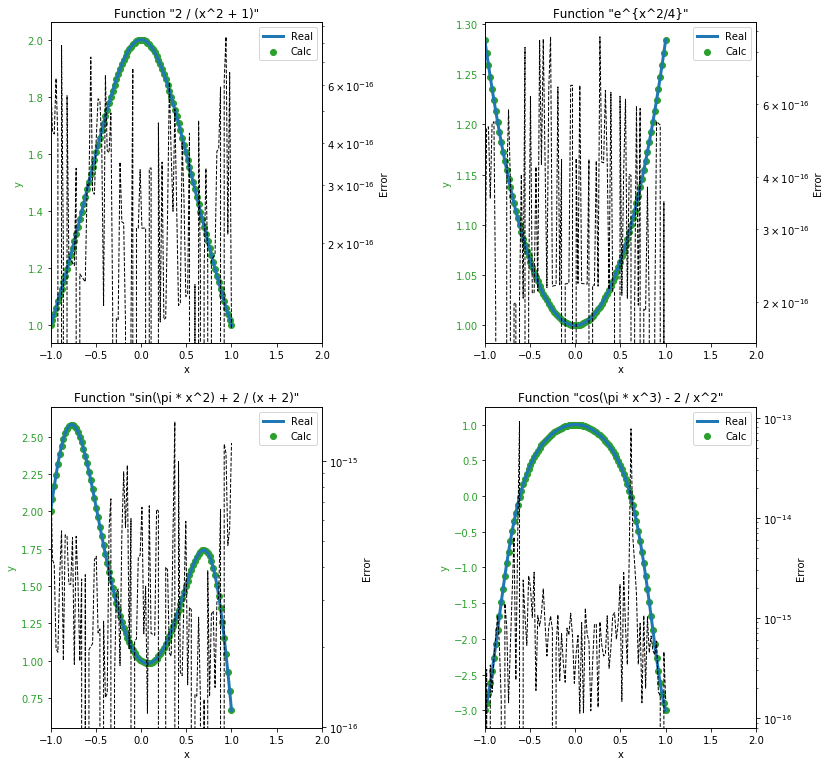

In [11]:
def func_f1(x): return 2. / (x**2 + 1.)
def func_f2(x): return np.exp(x**2 / 4.)
def func_f3(x): return np.sin(np.pi * x**2) + 2. / (x + 2.)
def func_f4(x): return np.cos(np.pi * x**3) - 2. * x**2

funcs = [
    '2 / (x^2 + 1)',
    'e^{x^2/4}',
    'sin(\pi * x^2) + 2 / (x + 2)',
    'cos(\pi * x^3) - 2 / x^2',
]

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u1 = func_f1(x).reshape(-1, 1)
u2 = func_f2(x).reshape(-1, 1)
u3 = func_f3(x).reshape(-1, 1)
u4 = func_f4(x).reshape(-1, 1)
a = Intertrain.interpolate(np.hstack([u1, u2, u3, u4]))

fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.6, hspace=0.2, width_ratios=[1, 1], height_ratios=[1, 1]
)

x = np.linspace(-1., 1., 100)

for k in range(len(funcs)):
    i = int(k / 2)
    j = k - 2*i
    
    u = eval('func_f%d'%(k+1))(x)
    v = Intertrain.polynomials(x, N).T@a[:, k]
    e = np.abs((v - u) / u)
    
    print('Max relative error for random points : %-8.2e | Func: %s'%(np.max(e), funcs[k]))

    ax1 = fig.add_subplot(gs[i, j])
    ax2 = ax1.twinx()
    
    ax1.set_title('Function "%s"'%funcs[k])
    ax1.set_xlabel('x')
    ax1.set_xlim(-1, 2)

    ax1.set_ylabel('y', color='tab:green')
    ax1.plot(x, u, color='tab:blue', linewidth=3, label='Real')
    ax1.scatter(x, v, color='tab:green', label='Calc')
    ax1.tick_params(axis='y', which='both', labelcolor='tab:green')
    ax1.legend(loc='best')

    ax2.set_ylabel('Error', color='black')
    ax2.plot(x, e, '--', linewidth=1, color='black')
    ax2.tick_params(axis='y', which='both', labelcolor='black')
    ax2.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Complexity estimation of 1D Chebyshev interpolation for several functions
    </div>
</div>

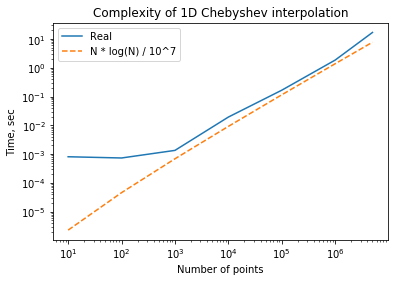

In [12]:
def func_f(x):
    return np.exp(x**2 / 4.)

k = 10
N = np.array([1E1, 1E2, 1E3, 1E4, 1E5, 1E6, 5E6])
T = np.array([])

for n in N:
    j = np.arange(n)
    x = np.cos(np.pi * j / (n-1))
    u = func_f(x).reshape(-1, 1)
    t = time.time()
    a = Intertrain.interpolate(np.repeat(u, k, axis=1))
    T = np.append(T, [time.time()-t])

C = N * np.log(N) / 1.0E7

plt.plot(N, T, label='Real')
plt.plot(N, C, '--', label='N * log(N) / 10^7')
plt.title('Complexity of 1D Chebyshev interpolation')
plt.xlabel('Number of points')
plt.ylabel('Time, sec')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

<div class="head1">
    <div class="head1__name">
        Chebyshev differentiation matrices
    </div>
</div>

<div class="head2">
    <div class="head2__name">
        Check for the matrix items
    </div>
</div>

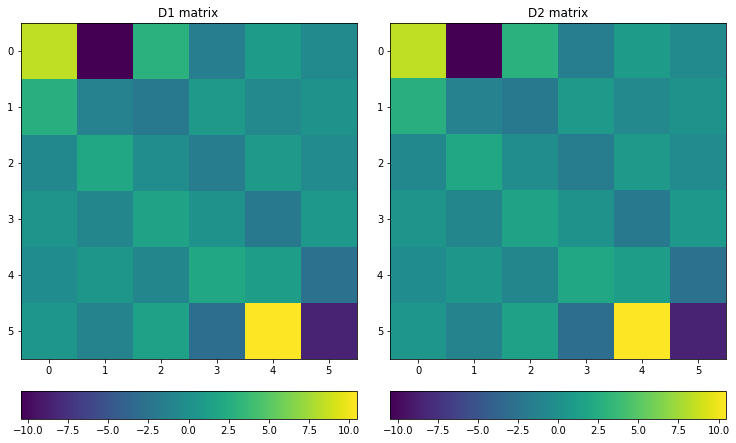

Error for D1 D1 = D2                       : 1.42e-14
Error for D1[0, 0] = (2N^2+1)/6            : 1.78e-15
Error for D1[0, 2] = + 2 / (1-x2)          : 0.00e+00
Error for D1[0, 3] = - 2 / (1-x3)          : 2.22e-16
Error for D1[4, 4] = - x[4] / 2 / (1-x4^2) : 6.66e-16


In [13]:
n = np.array([6]) 
l = np.array([[-1., 1.]])
N = n[0] - 1
IT = Intertrain(n, l)
D1 = IT.dif1()
D2 = IT.dif2()

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.1, hspace=0.02, width_ratios=[1, 1], height_ratios=[14, 1]
)

ax = fig.add_subplot(gs[0, 0])
ax.set_title('D1 matrix')
im = ax.imshow(D1)
ax = fig.add_subplot(gs[1, 0])
cb = plt.colorbar(im, cax=ax, orientation='horizontal')

ax = fig.add_subplot(gs[0, 1])
ax.set_title('D2 matrix')
im = ax.imshow(D1)
ax = fig.add_subplot(gs[1, 1])
cb = plt.colorbar(im, cax=ax, orientation='horizontal')

plt.show()

x = IT.grid()[0, :]

e = np.max(np.abs(D1@D1 - D2))
print('Error for D1 D1 = D2                       : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 0] - (2.*N**2+1.) / 6.
print('Error for D1[0, 0] = (2N^2+1)/6            : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 2] - 2. / (1. - x[2])
print('Error for D1[0, 2] = + 2 / (1-x2)          : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 3] + 2. / (1. - x[3])
print('Error for D1[0, 3] = - 2 / (1-x3)          : %-8.2e'%np.max(np.abs(e)))

e = D1[4, 4] + x[4] / (1. - x[4]**2) / 2.
print('Error for D1[4, 4] = - x[4] / 2 / (1-x4^2) : %-8.2e'%np.max(np.abs(e)))

<div class="head1">
    <div class="head1__name">
        1D PDE solution by Chebyshev differentiation matrix
    </div>
</div>

Consider a model PDE

$$
\Delta u(x) = f(x),
\quad
x \in [0, 4],
\quad
u(0) = 0,
\quad
u(4) = 0,
\quad
f(x) = -\pi^2 \sin{(\pi x)},
$$
with known exact solution
$$
u(x) = \sin{(\pi x)}.
$$

We can solve it on the Chebyshev grid using 2th order Chebyshev differentiation matrix from the system
$$
D u = f,
$$
excluding boundary points.

<div class="head2">
    <div class="head2__name">
        Direct solution
    </div>
</div>

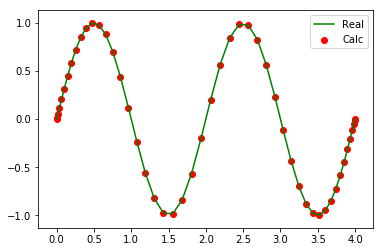

Number of spatial points :       50
Error                    : 9.16e-15    


In [14]:
def func_u(x):
    return np.sin(np.pi*x)

def func_f(x):
    return -1. * np.pi * np.pi * np.sin(np.pi*x)

IT = Intertrain(n=[50], l=[[0., 4.]])

X = IT.grid()
I = np.eye(IT.n[0])
J = np.eye(IT.n[0]); J[0, 0] = 0.; J[-1, -1] = 0.
D = J @ IT.dif2() + I - J
f = J @ (func_f(X).reshape(-1, 1))

u_calc = np.linalg.solve(D, f).reshape(-1)
u_real = func_u(X).reshape(-1)
e = np.linalg.norm(u_real-u_calc) / np.linalg.norm(u_real)
x = X.reshape(-1)

plt.plot(x, u_real, c='g', label='Real')
plt.scatter(x, u_calc, c='r', label='Calc')
plt.legend(loc='best')
plt.show()

print('Number of spatial points : %8d'%IT.n[0])
print('Error                    : %-12.2e'%e)

<div class="head2">
    <div class="head2__name">
        Time and convergence rates
    </div>
</div>

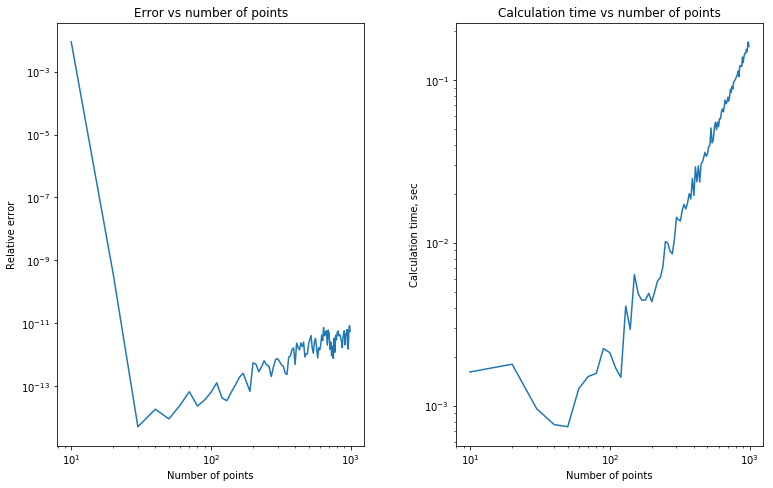

In [15]:
N = np.arange(10, 1000, 10)
T = []
E = []

for n in N:
    t = time.time()
    
    IT = Intertrain(n=[n], l=[[0., 4.]])

    X = IT.grid()
    I = np.eye(IT.n[0])
    J = np.eye(IT.n[0]); J[0, 0] = 0.; J[-1, -1] = 0.
    D = J @ IT.dif2() + I - J
    f = J @ (func_f(X).reshape(-1, 1))

    u_calc = np.linalg.solve(D, f).reshape(-1)
    u_real = func_u(X).reshape(-1)
    e = np.linalg.norm(u_real-u_calc) / np.linalg.norm(u_real)

    E.append(e) 
    T.append(time.time() - t)
    

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(N, E)
ax.set_title('Error vs number of points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(N, T)
ax.set_title('Calculation time vs number of points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
ax.semilogx()
ax.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        1D time dependent PDE solution by Chebyshev differentiation matrix
    </div>
</div>

Let consider a model PDE

$$
\frac{\partial \, u}{\partial \, t} = \Delta u(x)
\quad
x \in [-2, 1],
\quad
u(-2) = 0,
\quad
u(1) = 0,
\quad
u(x, 0) = \sin{(\pi x)},
$$
with known exact solution
$$
u(x, t) = \sin{(\pi x)} e^{-\pi^2t}.
$$

We can solve it for the time $t$ using uniform time grid with step $h$ and iterations
$$
u_{k+1}(x) = e^{h \cdot D_2} u_{k}(x),
\quad
k = 0, 1, \ldots, \frac{t}{h} - 1.
$$
where $u_{0}(x)$ is known initial condition.

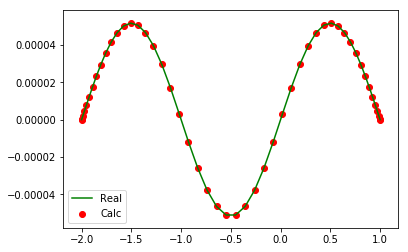

Number of time points    :    10000
Number of spatial points :       50
Error                    : 8.94e-10    


In [16]:
# Equation parameters

def func_u(x, t):
    return np.sin(np.pi*x) * np.exp(-1. * np.pi**2 * t)

def func_u0(x):
    return func_u(x, 0)

# Time grid

t_min = 0.
t_max = 1.
t_poi = 10000

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

# Spatial grid and Cheb. dif. matrix

n = 50

IT = Intertrain(n=[n], l=[[-2., 1.]])
X = IT.grid()
D = IT.dif2()

# Solution

J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

Z = expm(h * J @ D)

u = func_u0(X).reshape(-1)
for t in T[:-1]:
    u = Z@u

# Check result
    
t = t_max
x = X.reshape(-1)
v = func_u(X, t).reshape(-1)
e = np.linalg.norm(v - u) / np.linalg.norm(v)

# Output result

plt.plot(x, v, c='g', label='Real')
plt.scatter(x, u, c='r', label='Calc')
plt.legend(loc='best')
plt.show()


print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%IT.n[0])
print('Error                    : %-12.2e'%e)

<div class="head2">
    <div class="head2__name">
        Time and convergence rates vs number of spatial points
    </div>
</div>

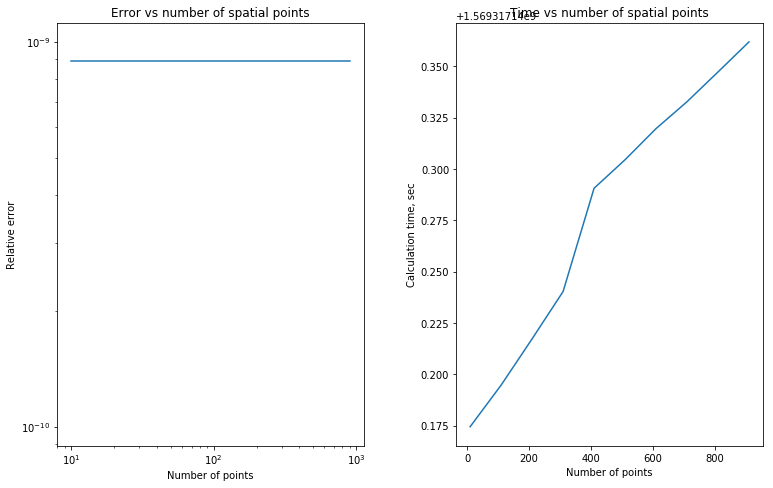

In [17]:
m = 10000
N = np.arange(10, 1000, 100)
Ts = []
Es = []

for n in N:
    t = time.time()

    t_min = 0.
    t_max = 1.
    t_poi = m

    h = (t_max - t_min) / (t_poi - 1)

    T = np.linspace(t_min, t_max, t_poi)

    n = 50

    IT = Intertrain(n=[n], l=[[-2., 1.]])
    X = IT.grid()
    D = IT.dif2()

    J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

    Z = expm(h * J @ D)

    u = func_u0(X).reshape(-1)
    for t in T[:-1]:
        u = Z@u

    t = t_max
    x = X.reshape(-1)
    v = func_u(X, t).reshape(-1)
    e = np.linalg.norm(v - u) / np.linalg.norm(v)

    Es.append(e)
    Ts.append(time.time() - t)
    
fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(N, Es)
ax.set_title('Error vs number of spatial points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(N, Ts)
ax.set_title('Time vs number of spatial points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
#ax.semilogx()
#ax.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Time and convergence rates vs number of time points
    </div>
</div>

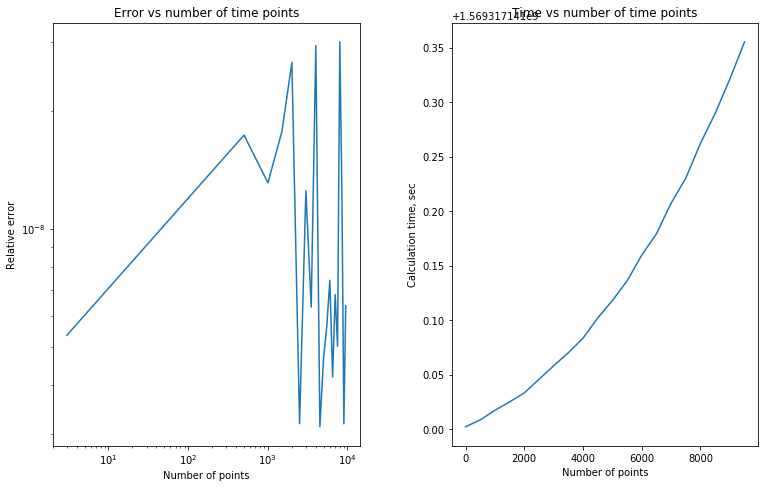

In [18]:
n = 100
M = np.arange(3, 10000, 500)
Ts = []
Es = []

for m in M:
    t = time.time()

    t_min = 0.
    t_max = 1.
    t_poi = m

    h = (t_max - t_min) / (t_poi - 1)

    T = np.linspace(t_min, t_max, t_poi)

    IT = Intertrain(n=[n], l=[[-1., 1.]])
    X = IT.grid()
    D = IT.dif2()

    J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

    Z = expm(h * J @ D)

    u = func_u0(X).reshape(-1)
    for t in T[:-1]:
        u = Z@u

    t = t_max
    x = X.reshape(-1)
    v = func_u(X, t).reshape(-1)
    e = np.linalg.norm(v - u) / np.linalg.norm(v)

    Es.append(e)
    Ts.append(time.time() - t)

    
fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(M, Es)
ax.set_title('Error vs number of time points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(M, Ts)
ax.set_title('Time vs number of time points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
#ax.semilogx()
#ax.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        Test for the cross approximation in the TT-format
    </div>
</div>

In [19]:
def f(x):
    return 1. + x[0, ] ** 1 + x[1, ] ** 2 + x[2, ] ** 3

def f_pois(i):
    return i

n = [5, 6, 7]
eps = 1.E-6
opts = {
    'nswp': 2,
}

Y, crs_res = Intertrain.cross(f, f_pois, n, eps, opts, './tmp.txt')
Y = Y.full()

I = np.array([
    [1, 2, 3, 4],
    [2, 1, 0, 3],
    [3, 2, 1, 0]
])
y_real = f(f_pois(I))
y_calc = np.array([Y[tuple(I[:, k])] for k in range(I.shape[1])])
err = np.abs((y_real - y_calc) / y_real)

print('Result: ', crs_res)
print('Errors: ', ', '.join(['%8.2e'%e for e in err]))

Result:  {'evals': 384, 't_func': 7.382283608118693e-07, 'iters': 2, 'err_rel': 2.3e-15, 'err_abs': 3.6e-12, 'erank': 5.0}
Errors:  0.00e+00, 2.96e-16, 0.00e+00, 2.54e-16
